In [1]:
# # Comparación de Algoritmos de Clasificación
#
# ## 📊 Análisis Comparativo de Modelos de Machine Learning
#
# En este notebook realizaremos una comparación sistemática de diferentes algoritmos de clasificación utilizando el dataset **Breast Cancer Wisconsin**. Los modelos evaluados son:
# - **K-Nearest Neighbors (KNN)**
# - **Support Vector Machine (SVM) con kernel RBF**
# - **Random Forest**
#
# ### Objetivos:
# 1. Cargar y explorar el dataset real
# 2. Preprocesar los datos y reducir dimensionalidad para visualización
# 3. Entrenar múltiples modelos de clasificación
# 4. Comparar métricas de rendimiento
# 5. Visualizar fronteras de decisión y curvas ROC
# 6. Determinar el mejor modelo para esta tarea
#
# ---


In [2]:
# ## 1. Instalación de Dependencias e Importaciones
#
# Utilizamos **scikit-learn** como framework principal junto con librerías complementarias para análisis y visualización.


In [3]:
# Instalación de dependencias
%pip install --quiet scikit-learn pandas matplotlib seaborn


In [4]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)

# Configuración para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Librerías importadas correctamente")


✅ Librerías importadas correctamente


In [5]:
# ## 2. Carga y Exploración del Dataset
#
# ### Dataset: Breast Cancer Wisconsin (Diagnóstico)
#
# **Descripción:**
# - **569 muestras** de tumores de mama
# - **30 características numéricas** extraídas de imágenes digitalizadas
# - **Problema binario de clasificación:**
#   - `0` = Maligno (canceroso)
#   - `1` = Benigno (no canceroso)
#
# Este es un dataset real ampliamente utilizado en machine learning para tareas de clasificación médica.


In [6]:
# Cargar dataset
data = load_breast_cancer()
X_full = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# Información del dataset
print("=" * 70)
print("INFORMACIÓN DEL DATASET")
print("=" * 70)
print(f"Dimensiones: {X_full.shape[0]} muestras × {X_full.shape[1]} características")
print(f"\nPrimeras 5 características:")
display(X_full.iloc[:, :5].head())

print("\n" + "=" * 70)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 70)
class_counts = y.value_counts().sort_index()
print(f"Clase 0 (Maligno):  {class_counts[0]} muestras ({class_counts[0]/len(y)*100:.1f}%)")
print(f"Clase 1 (Benigno):  {class_counts[1]} muestras ({class_counts[1]/len(y)*100:.1f}%)")


INFORMACIÓN DEL DATASET
Dimensiones: 569 muestras × 30 características

Primeras 5 características:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness
0,17.99,10.38,122.80,1001.0,0.11840
1,20.57,17.77,132.90,1326.0,0.08474
2,19.69,21.25,130.00,1203.0,0.10960
3,11.42,20.38,77.58,386.1,0.14250
4,20.29,14.34,135.10,1297.0,0.10030



DISTRIBUCIÓN DE CLASES
Clase 0 (Maligno):  212 muestras (37.3%)
Clase 1 (Benigno):  357 muestras (62.7%)


In [7]:
# ## 3. Preprocesamiento y Reducción Dimensional
#
# ### Estrategia de Preprocesamiento:
#
# 1. **Estandarización:** Normalizamos las características usando `StandardScaler` para que tengan media 0 y desviación estándar 1. Esto es crucial para algoritmos sensibles a la escala como KNN y SVM.
#
# 2. **Reducción Dimensional con PCA:** Reducimos las 30 características a 2 componentes principales para:
#    - Facilitar la visualización en 2D
#    - Mostrar fronteras de decisión de forma intuitiva
#
# ⚠️ **Nota importante:** La reducción a 2 dimensiones puede perder información. En producción, se entrenaría con todas las características originales para maximizar el rendimiento.


In [8]:
# Estandarización de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)

# Reducción dimensional con PCA
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Análisis de varianza explicada
explained_variance = pca.explained_variance_ratio_
print("=" * 70)
print("ANÁLISIS PCA")
print("=" * 70)
print(f"Varianza explicada por PC1: {explained_variance[0]:.1%}")
print(f"Varianza explicada por PC2: {explained_variance[1]:.1%}")
print(f"Varianza total explicada:   {explained_variance.sum():.1%}")
print("\n⚠️  Aproximadamente el {:.1%} de la información se pierde con la reducción a 2D".format(
    1 - explained_variance.sum()
))

# Crear DataFrame con componentes principales
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_pca["target"] = y.values

print("\n" + "=" * 70)
print("DATOS TRANSFORMADOS (PCA)")
print("=" * 70)
display(df_pca.head(10))


ANÁLISIS PCA
Varianza explicada por PC1: 44.3%
Varianza explicada por PC2: 19.0%
Varianza total explicada:   63.2%

⚠️  Aproximadamente el 36.8% de la información se pierde con la reducción a 2D

DATOS TRANSFORMADOS (PCA)


,PC1,PC2,target
0,9.192837,1.948583,0
1,2.387802,-3.768172,0
2,5.733896,-1.075174,0
3,7.122953,10.275589,0
4,3.935302,-1.948072,0
5,2.380247,3.949929,0
6,2.238883,-2.690031,0
7,2.143299,2.340244,0
8,3.174924,3.391813,0
9,6.351747,7.727174,0


In [9]:
# ## 4. División de Datos: Entrenamiento y Prueba
#
# Dividimos el dataset en:
# - **75% para entrenamiento** (426 muestras)
# - **25% para prueba** (143 muestras)
#
# Utilizamos `stratify=y` para mantener la proporción de clases en ambos conjuntos.


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y.values,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y.values
)

print("=" * 70)
print("DIVISIÓN TRAIN/TEST")
print("=" * 70)
print(f"📊 Conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"📊 Conjunto de prueba:        {X_test.shape[0]} muestras")
print(f"\n✅ División completada correctamente")


DIVISIÓN TRAIN/TEST
📊 Conjunto de entrenamiento: 426 muestras
📊 Conjunto de prueba:        143 muestras

✅ División completada correctamente


In [11]:
# ## 5. Definición de Modelos
#
# Configuramos tres algoritmos de clasificación con parámetros por defecto (sin ajuste de hiperparámetros):
#
# ### 🔹 K-Nearest Neighbors (KNN)
# - Clasificador basado en proximidad
# - `n_neighbors=5` por defecto
# - Sensible a la escala (datos ya estandarizados)
#
# ### 🔹 Support Vector Machine (SVM)
# - Kernel RBF (Radial Basis Function)
# - Busca el hiperplano óptimo de separación
# - `probability=True` para obtener probabilidades y calcular ROC-AUC
#
# ### 🔹 Random Forest
# - Ensemble de árboles de decisión
# - Robusto a outliers y overfitting
# - Maneja relaciones no lineales de forma natural


In [12]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)": SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

print("=" * 70)
print("MODELOS CONFIGURADOS")
print("=" * 70)
for name, model in models.items():
    print(f"✅ {name}: {type(model).__name__}")


MODELOS CONFIGURADOS
✅ KNN: KNeighborsClassifier
✅ SVM (RBF): SVC
✅ RandomForest: RandomForestClassifier


In [13]:
# ## 6. Entrenamiento y Evaluación de Modelos
#
# En esta etapa:
# 1. Entrenamos cada modelo con el conjunto de entrenamiento
# 2. Realizamos predicciones en el conjunto de prueba
# 3. Calculamos múltiples métricas de evaluación:
#    - **Accuracy**: Proporción de predicciones correctas
#    - **Precision**: De las predicciones positivas, cuántas son correctas
#    - **Recall**: De los casos positivos reales, cuántos detectamos
#    - **F1-Score**: Media armónica entre precision y recall
#    - **AUC-ROC**: Área bajo la curva ROC (capacidad de discriminación)


In [14]:
results = []
probs = {}
preds = {}

print("=" * 70)
print("ENTRENAMIENTO Y EVALUACIÓN")
print("=" * 70)

for name, clf in models.items():
    print(f"\n🔄 Entrenando {name}...", end=" ")

    # Entrenar modelo
    clf.fit(X_train, y_train)

    # Predicciones
    y_pred = clf.predict(X_test)

    # Obtener probabilidades para ROC-AUC
    if hasattr(clf, "predict_proba"):
        y_prob = clf.predict_proba(X_test)[:, 1]
    else:
        try:
            dfc = clf.decision_function(X_test)
            y_prob = (dfc - dfc.min()) / (dfc.max() - dfc.min())
        except Exception:
            y_prob = np.zeros_like(y_pred, dtype=float)

    # Calcular métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Almacenar resultados
    results.append({
        "Modelo": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "AUC": auc
    })
    probs[name] = y_prob
    preds[name] = y_pred

    print("✅")
    print(f"   Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

print("\n" + "=" * 70)
print("✅ Entrenamiento completado para todos los modelos")
print("=" * 70)


ENTRENAMIENTO Y EVALUACIÓN

🔄 Entrenando KNN... ✅
   Accuracy: 0.9371 | Precision: 0.9451 | Recall: 0.9556 | F1: 0.9503 | AUC: 0.9713

🔄 Entrenando SVM (RBF)... ✅
   Accuracy: 0.9510 | Precision: 0.9462 | Recall: 0.9778 | F1: 0.9617 | AUC: 0.9887

🔄 Entrenando RandomForest... ✅
   Accuracy: 0.9371 | Precision: 0.9451 | Recall: 0.9556 | F1: 0.9503 | AUC: 0.9866

✅ Entrenamiento completado para todos los modelos


In [15]:
# ## 7. Comparación de Métricas
#
# Tabla resumen con todas las métricas de evaluación, ordenada por AUC (Area Under the Curve) de mayor a menor.


In [16]:
df_results = pd.DataFrame(results).sort_values(by="AUC", ascending=False).reset_index(drop=True)
pd.set_option("display.precision", 4)

print("\n" + "=" * 70)
print("📊 TABLA COMPARATIVA DE MÉTRICAS (Conjunto de Prueba)")
print("=" * 70)
display(df_results)



📊 TABLA COMPARATIVA DE MÉTRICAS (Conjunto de Prueba)


,Modelo,Accuracy,Precision,Recall,F1-Score,AUC
0,SVM (RBF),0.9510,0.9462,0.9778,0.9617,0.9887
1,RandomForest,0.9371,0.9451,0.9556,0.9503,0.9866
2,KNN,0.9371,0.9451,0.9556,0.9503,0.9713


In [17]:
# ## 8. Visualización de Fronteras de Decisión
#
# Representamos gráficamente cómo cada modelo divide el espacio de características en las dos clases. Las regiones coloreadas muestran la predicción del modelo para cada punto del espacio 2D (PC1, PC2).
#
# - **Regiones de color:** Clasificación predicha por el modelo
# - **Puntos:** Muestras reales del conjunto de prueba
# - **Color de puntos:** Clase real (amarillo/azul)


/tmp/ipython-input-2469195180.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


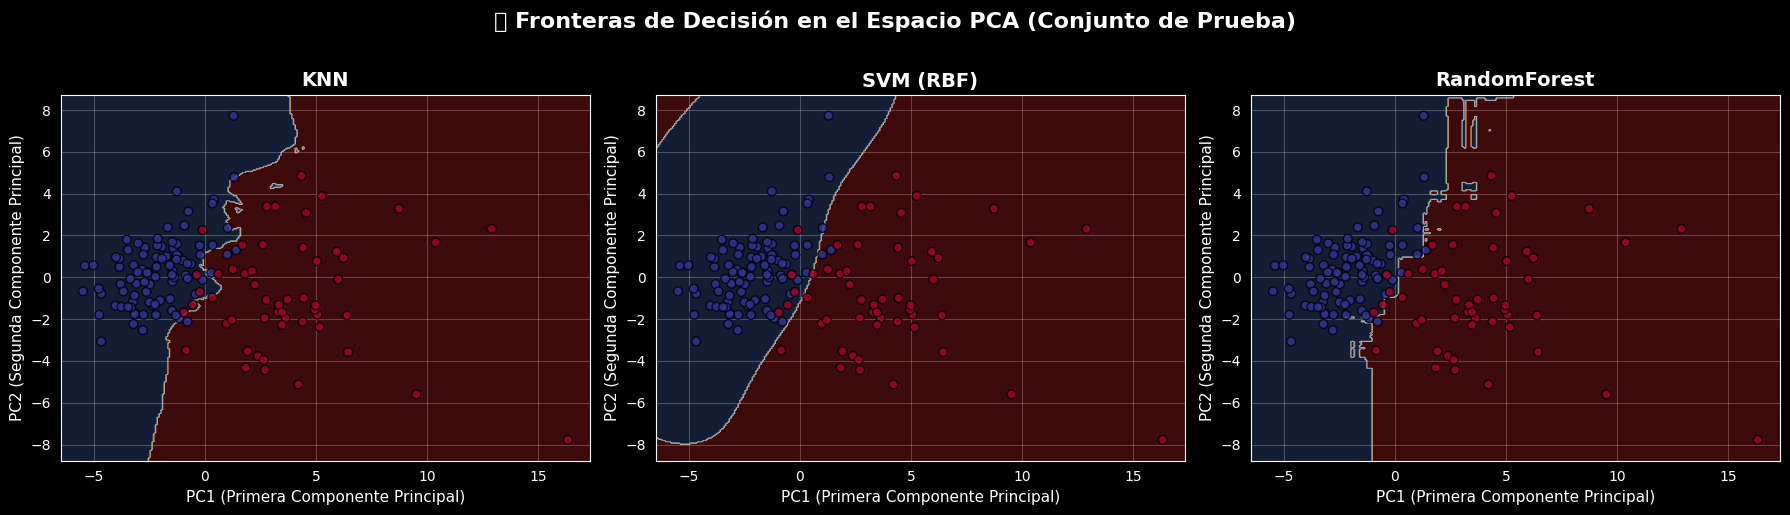

In [18]:
def plot_decision_boundary_clf(clf, X, y, ax, title):
    """Dibuja las fronteras de decisión de un clasificador en 2D"""
    # Crear malla de puntos
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )

    # Predecir en la malla
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = clf.predict(grid)
    Z = Z.reshape(xx.shape)

    # Dibujar contornos y puntos
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k',
                         cmap='RdYlBu', alpha=0.8)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("PC1 (Primera Componente Principal)", fontsize=11)
    ax.set_ylabel("PC2 (Segunda Componente Principal)", fontsize=11)
    ax.grid(True, alpha=0.3)

# Crear visualización
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, clf) in zip(axes, models.items()):
    plot_decision_boundary_clf(clf, X_test, y_test, ax, title=name)

plt.suptitle("🎯 Fronteras de Decisión en el Espacio PCA (Conjunto de Prueba)",
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [19]:
# ## 9. Curvas ROC (Receiver Operating Characteristic)
#
# La **curva ROC** muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) a diferentes umbrales de clasificación.
#
# - **AUC (Area Under Curve):** Métrica resumen. Valores cercanos a 1.0 indican excelente capacidad de discriminación.
# - **Línea diagonal (azar):** Representa un clasificador aleatorio (AUC = 0.5)
# - **Mejor modelo:** Curva que se acerca más a la esquina superior izquierda


/tmp/ipython-input-86448511.py:20: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


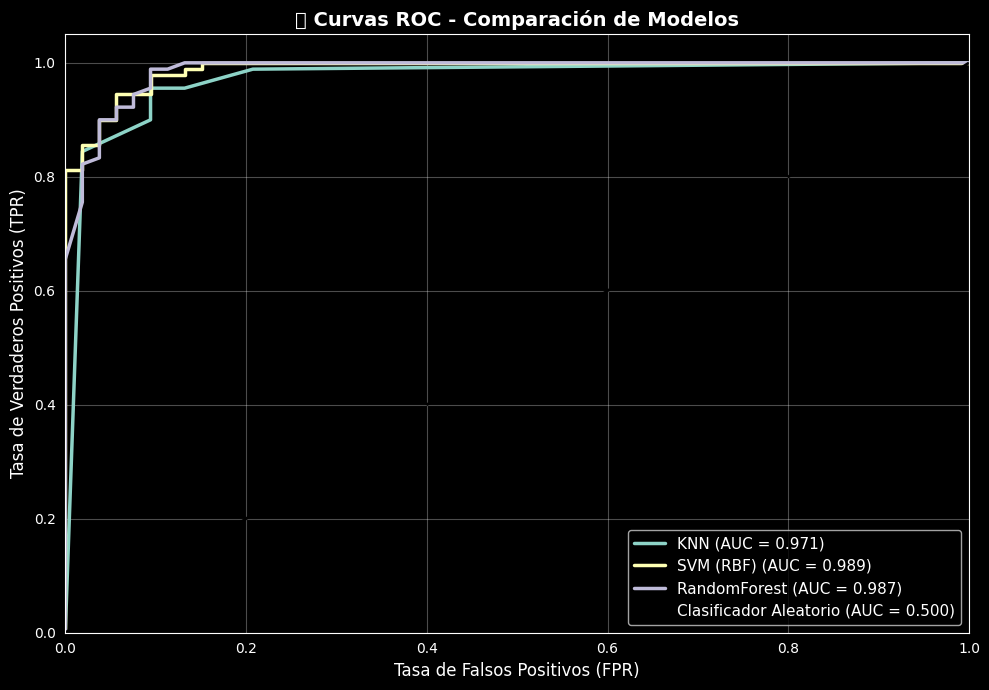

In [20]:
plt.figure(figsize=(10, 7))

# Dibujar curva ROC para cada modelo
for name, y_prob in probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    plt.plot(fpr, tpr, linewidth=2.5, label=f"{name} (AUC = {auc:.3f})")

# Línea de azar
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label="Clasificador Aleatorio (AUC = 0.500)")

# Configuración del gráfico
plt.xlabel("Tasa de Falsos Positivos (FPR)", fontsize=12)
plt.ylabel("Tasa de Verdaderos Positivos (TPR)", fontsize=12)
plt.title("📈 Curvas ROC - Comparación de Modelos", fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()


In [21]:
# ## 10. Matrices de Confusión y Reportes Detallados
#
# La **matriz de confusión** muestra:
# - **Verdaderos Negativos (TN):** Malignos correctamente identificados
# - **Falsos Positivos (FP):** Benignos incorrectamente clasificados como malignos
# - **Falsos Negativos (FN):** Malignos incorrectamente clasificados como benignos ⚠️ **Crítico en medicina**
# - **Verdaderos Positivos (TP):** Benignos correctamente identificados


In [22]:
for name, y_pred in preds.items():
    print("\n" + "=" * 70)
    print(f"📋 ANÁLISIS DETALLADO: {name}")
    print("=" * 70)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(
        cm,
        index=["Real: Maligno (0)", "Real: Benigno (1)"],
        columns=["Predicho: Maligno (0)", "Predicho: Benigno (1)"]
    )
    print("\n🔢 Matriz de Confusión:")
    display(df_cm)

    # Reporte de clasificación
    print("\n📊 Reporte de Clasificación:")
    print(classification_report(
        y_test, y_pred,
        target_names=["Maligno", "Benigno"],
        digits=4
    ))



📋 ANÁLISIS DETALLADO: KNN

🔢 Matriz de Confusión:


,Predicho: Maligno (0),Predicho: Benigno (1)
Real: Maligno (0),48,5
Real: Benigno (1),4,86



📊 Reporte de Clasificación:
              precision    recall  f1-score   support

     Maligno     0.9231    0.9057    0.9143        53
     Benigno     0.9451    0.9556    0.9503        90

    accuracy                         0.9371       143
   macro avg     0.9341    0.9306    0.9323       143
weighted avg     0.9369    0.9371    0.9369       143


📋 ANÁLISIS DETALLADO: SVM (RBF)

🔢 Matriz de Confusión:


,Predicho: Maligno (0),Predicho: Benigno (1)
Real: Maligno (0),48,5
Real: Benigno (1),2,88



📊 Reporte de Clasificación:
              precision    recall  f1-score   support

     Maligno     0.9600    0.9057    0.9320        53
     Benigno     0.9462    0.9778    0.9617        90

    accuracy                         0.9510       143
   macro avg     0.9531    0.9417    0.9469       143
weighted avg     0.9513    0.9510    0.9507       143


📋 ANÁLISIS DETALLADO: RandomForest

🔢 Matriz de Confusión:


,Predicho: Maligno (0),Predicho: Benigno (1)
Real: Maligno (0),48,5
Real: Benigno (1),4,86



📊 Reporte de Clasificación:
              precision    recall  f1-score   support

     Maligno     0.9231    0.9057    0.9143        53
     Benigno     0.9451    0.9556    0.9503        90

    accuracy                         0.9371       143
   macro avg     0.9341    0.9306    0.9323       143
weighted avg     0.9369    0.9371    0.9369       143



In [23]:
# ## 11. Conclusiones y Recomendaciones
#
# Análisis final del rendimiento de los modelos y recomendaciones para el despliegue.


In [24]:
best_idx = df_results['AUC'].idxmax()
best_model_name = df_results.loc[best_idx, 'Modelo']
best_auc = df_results.loc[best_idx, 'AUC']

print("\n" + "=" * 70)
print("🏆 CONCLUSIONES FINALES")
print("=" * 70)

print("\n📊 Resumen de Rendimiento:")
for i, row in df_results.iterrows():
    position = "🥇" if i == 0 else "🥈" if i == 1 else "🥉"
    print(f"{position} {row['Modelo']:15} → Accuracy: {row['Accuracy']:.4f} | F1: {row['F1-Score']:.4f} | AUC: {row['AUC']:.4f}")

print(f"\n🎯 MEJOR MODELO: {best_model_name}")
print(f"   AUC: {best_auc:.4f}")

print("\n" + "=" * 70)
print("💡 OBSERVACIONES IMPORTANTES")
print("=" * 70)
print("""
✅ Se utilizó el dataset real Breast Cancer Wisconsin (569 muestras, 30 características)
✅ Los datos fueron estandarizados y reducidos a 2D con PCA para visualización
✅ División estratificada: 75% entrenamiento / 25% prueba
✅ Se evaluaron tres algoritmos: KNN, SVM (RBF) y Random Forest

⚠️  LIMITACIONES:
   • La reducción a 2 componentes principales (PCA) pierde ~{:.1%} de varianza
   • No se realizó ajuste de hiperparámetros (tuning)
   • Para aplicaciones en producción, entrenar con las 30 características originales

🔬 RECOMENDACIONES PARA MEJORA:
   • Realizar validación cruzada (cross-validation)
   • Optimizar hiperparámetros con GridSearch o RandomSearch
   • Evaluar con más métricas específicas del dominio médico
   • Considerar el costo de falsos negativos (casos malignos no detectados)
""".format(1 - explained_variance.sum()))

print("=" * 70)
print("✅ Análisis completado exitosamente")
print("=" * 70)



🏆 CONCLUSIONES FINALES

📊 Resumen de Rendimiento:
🥇 SVM (RBF)       → Accuracy: 0.9510 | F1: 0.9617 | AUC: 0.9887
🥈 RandomForest    → Accuracy: 0.9371 | F1: 0.9503 | AUC: 0.9866
🥉 KNN             → Accuracy: 0.9371 | F1: 0.9503 | AUC: 0.9713

🎯 MEJOR MODELO: SVM (RBF)
   AUC: 0.9887

💡 OBSERVACIONES IMPORTANTES

✅ Se utilizó el dataset real Breast Cancer Wisconsin (569 muestras, 30 características)
✅ Los datos fueron estandarizados y reducidos a 2D con PCA para visualización
✅ División estratificada: 75% entrenamiento / 25% prueba
✅ Se evaluaron tres algoritmos: KNN, SVM (RBF) y Random Forest

⚠️  LIMITACIONES:
   • La reducción a 2 componentes principales (PCA) pierde ~36.8% de varianza
   • No se realizó ajuste de hiperparámetros (tuning)
   • Para aplicaciones en producción, entrenar con las 30 características originales

🔬 RECOMENDACIONES PARA MEJORA:
   • Realizar validación cruzada (cross-validation)
   • Optimizar hiperparámetros con GridSearch o RandomSearch
   • Evaluar con m